In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [280]:
data = pd.read_csv('sensorfiber_x1000-dmm-11.csv')

In [281]:
data.drop(columns=['Unnamed: 1', 'sensor'], inplace=True)

In [282]:
# convert Resistance to float and Time to seconds
data['Resistance'] = data['Resistance'].astype(float)
def time_to_seconds(t):
    h, m, s = t.split(":")
    s, micro = map(float, s.split("."))
    micro = micro / 1000000
    return int(h) * 3600 + int(m) * 60 + s + micro

data["Time in Seconds"] = data["Time"].apply(time_to_seconds)

# Identify new day (when time decreases)
data["Day"] = (data["Time in Seconds"] < data["Time in Seconds"].shift()).cumsum()

# Add date based on day counter
data["Full Datetime"] = pd.to_datetime("2023-01-01") + pd.to_timedelta(data["Day"], unit="D") + pd.to_timedelta(data["Time"])

data['Time Elapsed'] = (data['Full Datetime'] - data['Full Datetime'].iloc[0]).dt.total_seconds()

In [283]:
R_0 = data['Resistance'].iloc[0] 
# 100 * (R-R0)/R0 
data['Percent Change'] = 100 * (data['Resistance'] - R_0) / R_0

In [284]:
# remove data before 3.4 seconds
df = data[data["Time Elapsed"] > 3.4].copy()

In [285]:
df['Time Elapsed'] = df['Time Elapsed'] - df['Time Elapsed'].iloc[0]

In [286]:
# Calculate the cycle id. Use a threshold to determine when a new cycle starts.
# Use plots to find a good threshold.
def assign_cycleid(df, value_col, threshold):
    cycle_ids = []
    cycle_counter = 0
    above = False  
    for val in df[value_col]:
        if val > threshold:
            if not above:  
                cycle_counter += 1
                above = True
            cycle_ids.append(cycle_counter)
        else:
            above = False
            cycle_ids.append(0)

    df = df.copy()
    df["cycleid"] = cycle_ids
    return df

In [287]:
df = assign_cycleid(df, "Resistance", 67)

In [288]:
# find the main portion of each cycle with some padding
def get_cycle_window(df, cycle_number, pad=7):
    df = df.copy()
    cyc_data = df[df["cycleid"] == cycle_number]
    if cyc_data.empty:
        return pd.DataFrame()  
    start = cyc_data["Time Elapsed"].min()
    end   = cyc_data["Time Elapsed"].max()

    window_start = start - pad
    window_end   = end + pad

    return df[(df["Time Elapsed"] >= window_start) & (df["Time Elapsed"] <= window_end)]


In [289]:
c100 = df[(df['Time Elapsed'] <= 7551) & (df['Time Elapsed'] >= 7475.5)]
c200 = df[(df['Time Elapsed'] <= 15100) & (df['Time Elapsed'] >= 15025)]
c300 = df[(df['Time Elapsed'] >= 22573) & (df['Time Elapsed'] <= 22649)]
c400 = df[(df['Time Elapsed'] >= 30122.5) & (df['Time Elapsed'] <= 30198.5)]
c500 = df[(df['Time Elapsed'] >= 37672) & (df['Time Elapsed'] <= 37747)]
c600 = df[(df['Time Elapsed'] >= 45227) & (df['Time Elapsed'] <= 45301)]
c700 = df[(df['Time Elapsed'] >= 52775) & (df['Time Elapsed'] <= 52850)]
c800 = df[(df['Time Elapsed'] >= 60324) & (df['Time Elapsed'] <= 60400)]
c900 = df[(df['Time Elapsed'] >= 67877) & (df['Time Elapsed'] <= 67952)]
c1000 = df[(df['Time Elapsed'] >= 75426) & (df['Time Elapsed'] <= 75500)]
c1 = df[(df['Time Elapsed'] >= 0) & (df['Time Elapsed'] <= 75.6)]

In [290]:
# get a subset for a certain cycle
c = get_cycle_window(df, 1) 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


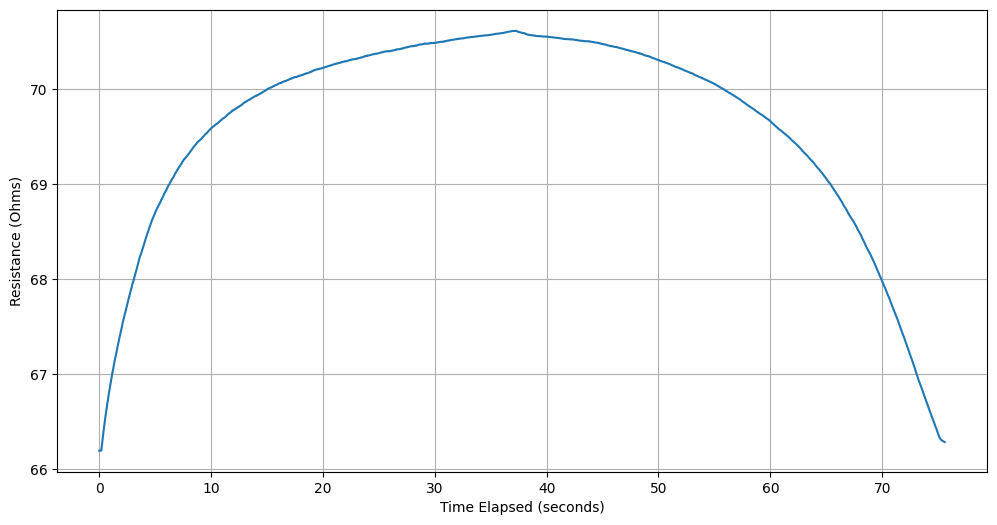

In [291]:
# find precise start and end points for the cycle
plt.figure(figsize=(12, 6))
# sns.lineplot(data=c, x='Time Elapsed', y='Resistance') 
sns.lineplot(data = df[(df['Time Elapsed'] >= 0) & (df['Time Elapsed'] <= 75.6)], x='Time Elapsed', y='Resistance')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Resistance (Ohms)')
plt.grid()
plt.show()

In [292]:
# color function to generate n colors from red to black
def red_to_black(n):
    """
    Generate n colors from red (cycle 1) to black (cycle n).
    Returns a list of RGB tuples.
    """
    colors = []
    for i in range(n):
        frac = 1 - i / (n - 1) if n > 1 else 1.0  
        colors.append((frac, 0.0, 0.0))           
    return colors

In [293]:
# calculate strain 
def make_strain_profile(n_points, max_strain=30.0):
    n_up = n_points // 2
    n_dn = n_points - n_up
    up = np.linspace(0.0, max_strain, n_up, endpoint=True)
    dn = np.linspace(max_strain, 0.0, n_dn, endpoint=True)
    return np.concatenate([up, dn])


In [294]:
# Plot selected cycles
def plot_cycles(subsets, cycles, startpt = (0, 1.5), endpt = (2, 3)):
    """
    subsets : list[pd.DataFrame], each has 'Resistance Change'
    cycles  : list[int], same length as subsets
    """
    # sort cycles for consistent color mapping
    order = np.argsort(cycles)
    subsets = [subsets[i] for i in order]
    cycles  = [cycles[i]  for i in order]

    # red→black palette
    palette = red_to_black(len(cycles))

    plt.figure(figsize=(7, 5), dpi=150)

    for i, (df_sub, c) in enumerate(zip(subsets, cycles)):
        if df_sub is None or len(df_sub) == 0:
            continue
        x = make_strain_profile(len(df_sub), max_strain=30.0)
        y = df_sub["Percent Change"].to_numpy()
        plt.plot(x, y, color=palette[i], label=f'cycle {c}')


    plt.annotate("", xytext=startpt, xy=endpt,
                 arrowprops=dict(arrowstyle="->"))

    plt.legend()
    plt.xlabel('Strain (%)', fontsize=15)
    plt.ylabel(u'Δ Resistance (%)', fontsize=15)
    plt.grid()
    plt.tight_layout()
    plt.show()


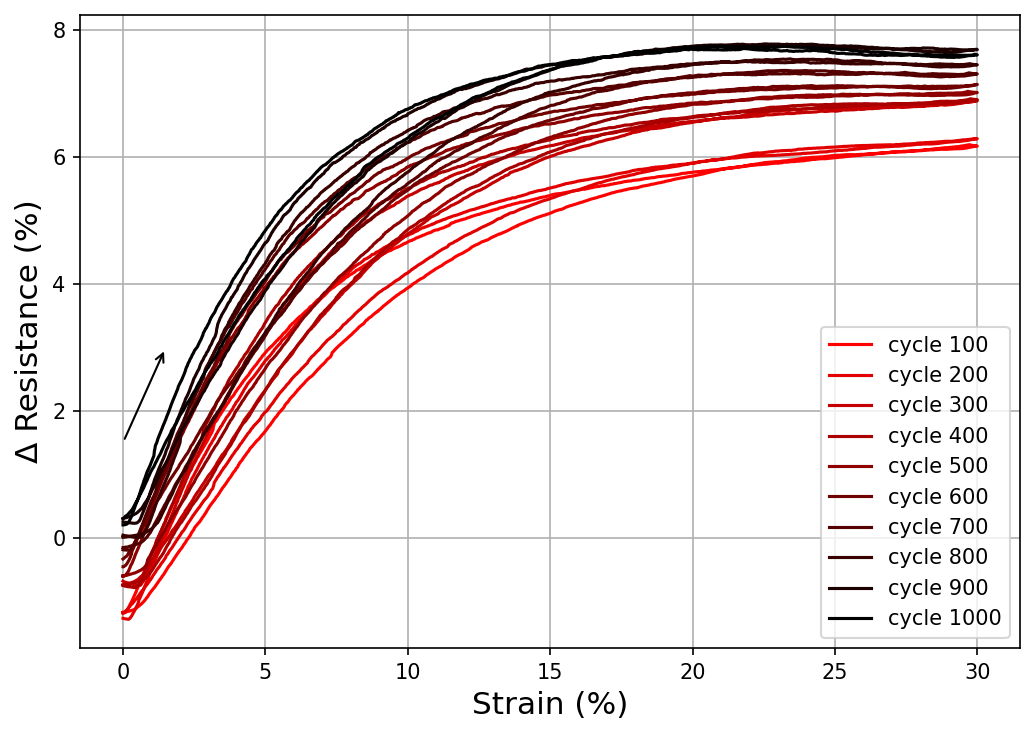

In [295]:
cycles = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
subsets = [c100, c200, c300, c400, c500, c600, c700, c800, c900, c1000]
plot_cycles(subsets, cycles, startpt=(0, 1.5), endpt=(1.5, 3))

In [296]:
df500 = pd.read_csv('oldthreadsensorfiber_500x_everythingtightened-dmm-11_trimmed.csv')
df500.drop(columns=['Unnamed: 1', 'sensor'], inplace=True)

In [297]:
df500['Resistance'] = df500['Resistance'].astype(float)

df500["Time in Seconds"] = df500["Time"].apply(time_to_seconds)

df500["Day"] = (df500["Time in Seconds"] < df500["Time in Seconds"].shift()).cumsum()

df500["Full Datetime"] = pd.to_datetime("2023-01-01") + pd.to_timedelta(df500["Day"], unit="D") + pd.to_timedelta(df500["Time"])

df500['Time Elapsed'] = (df500['Full Datetime'] - df500['Full Datetime'].iloc[0]).dt.total_seconds()

In [298]:
R_0 = df500['Resistance'].iloc[0] 
df500['Percent Change'] = 100 * (df500['Resistance'] - R_0) / R_0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


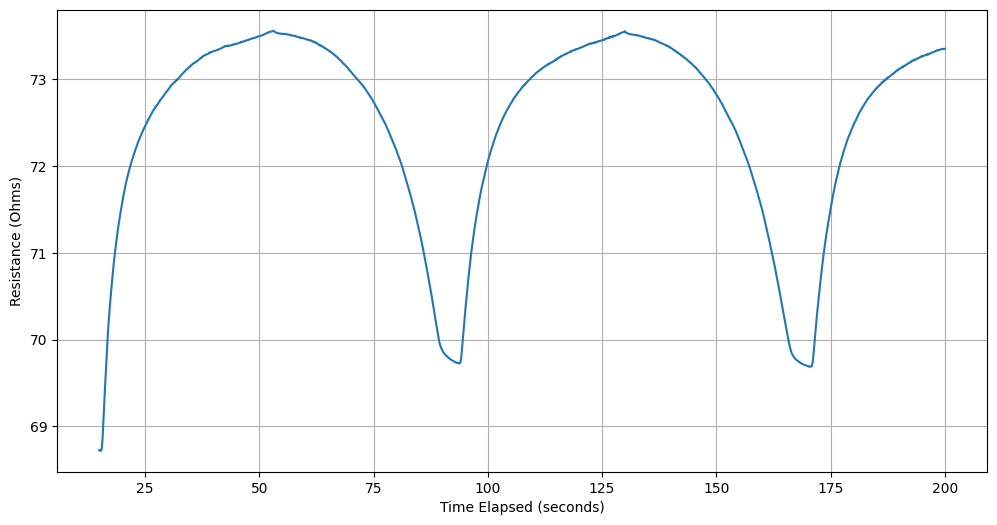

In [299]:
# find the threshold 
plt.figure(figsize=(12, 6))
# sns.lineplot(data=c, x='Time Elapsed', y='Resistance') # 200th 
sns.lineplot(data = df500[(df500['Time Elapsed'] >= 15) & (df500['Time Elapsed'] <= 200)], x='Time Elapsed', y='Resistance')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Resistance (Ohms)')
plt.grid()
plt.show()

In [300]:
df500 = df500[df500["Time Elapsed"] > 15].copy()
df500['Time Elapsed'] = df500['Time Elapsed'] - df500['Time Elapsed'].iloc[0]

In [301]:
df500 = assign_cycleid(df500, "Resistance", 70.5)

In [302]:
s1 = df500[(df500['Time Elapsed'] >= 0) & (df500['Time Elapsed'] <= 79)]
s50 = df500[(df500['Time Elapsed'] >= 3770) & (df500['Time Elapsed'] <= 3845)]
s100 = df500[(df500['Time Elapsed'] >= 7616) & (df500['Time Elapsed'] <= 7690)]
s150 = df500[(df500['Time Elapsed'] >= 11462) & (df500['Time Elapsed'] <= 11535)]
s200 = df500[(df500['Time Elapsed'] >= 15307) & (df500['Time Elapsed'] <= 15381)]
s250 = df500[(df500['Time Elapsed'] >= 19154) & (df500['Time Elapsed'] <= 19227)]
s300 = df500[(df500['Time Elapsed'] >= 23000) & (df500['Time Elapsed'] <= 23075)]
s350 = df500[(df500['Time Elapsed'] >= 26848) & (df500['Time Elapsed'] <= 26920)]
s400 = df500[(df500['Time Elapsed'] >= 30694) & (df500['Time Elapsed'] <= 30769)]
s450 = df500[(df500['Time Elapsed'] >= 34540) & (df500['Time Elapsed'] <= 34613)]
s500 = df500[(df500['Time Elapsed'] >= 38387) & (df500['Time Elapsed'] <= 38460)]

In [303]:
c = get_cycle_window(df500, 500)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


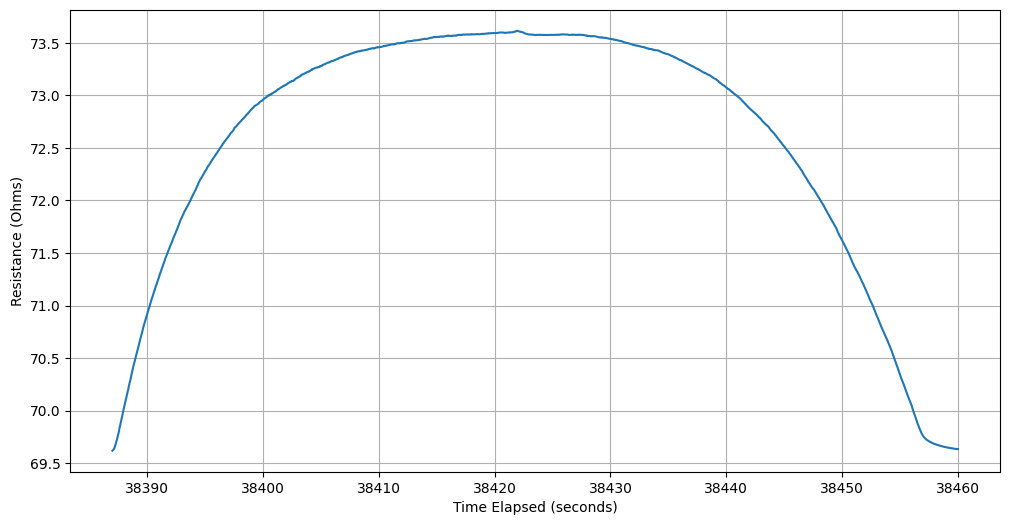

In [304]:
plt.figure(figsize=(12, 6))
# sns.lineplot(data=c, x='Time Elapsed', y='Resistance') # 200th 
sns.lineplot(data = df500[(df500['Time Elapsed'] >= 38387) & (df500['Time Elapsed'] <= 38460)], x='Time Elapsed', y='Resistance')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Resistance (Ohms)')
plt.grid()
plt.show()

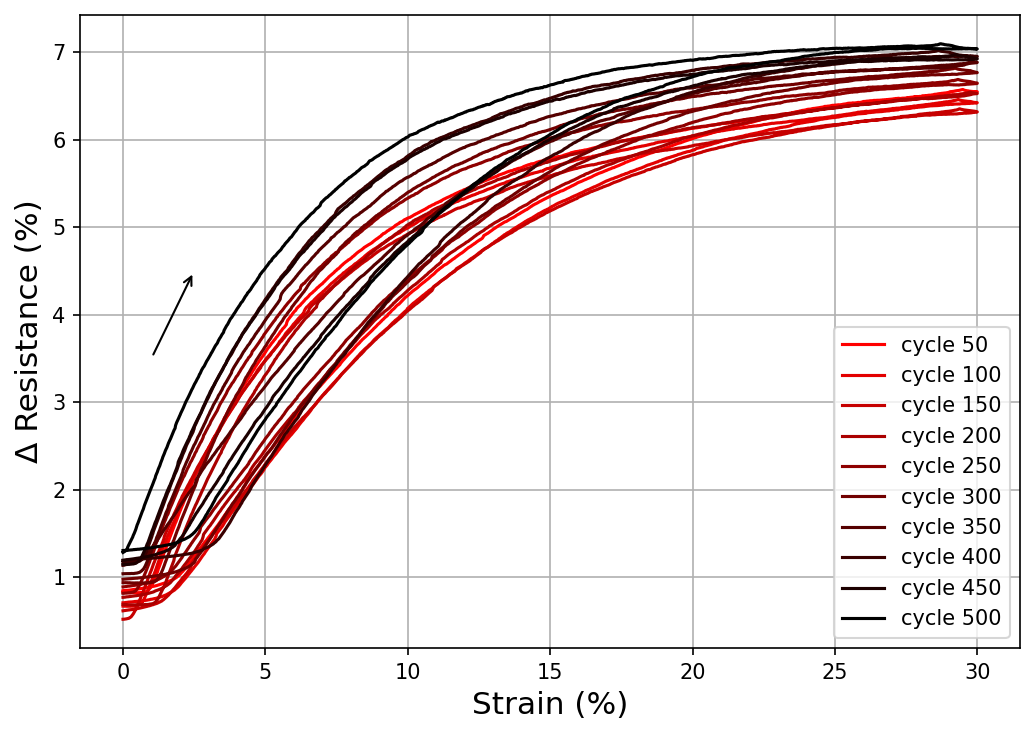

In [305]:
cycles500 = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
subsets500 = [s50, s100, s150, s200, s250, s300, s350, s400, s450, s500]
plot_cycles(subsets500, cycles500, startpt=(1, 3.5), endpt=(2.5, 4.5))